In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [60]:
#Cargar el dataset
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv")

# Ver las primeras filas
df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Exploración inicial

In [61]:
# Dimensiones
print("Shape:", df.shape)

Shape: (48895, 16)


El dataframe tiene 16 columnas y 48895 filas

In [62]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Podemos observar que tenemos las siguientes **variables categóricas:** id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type.  


Y las siguientes **variables numéricas:** latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count


In [63]:
# Conteo de nulos por columna
df.isnull().sum()


id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [64]:
# Porcentaje de nulos
df.isnull().mean() * 100

id                                 0.000000
name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

**Eliminar variables:**

¿Por qué elimiar **last_review y number_of_reviews**? 

Podemos observar que las variables last_review y number_of_reviews tiene muchos datos nulos y no nos aportan información relevante para el precio, además que tenemos la variable number_of_reviews si queremos ver la relación con el precio de las reseñas. 

 ¿Por qué eliminar **id, name, host_id, host_name**?  

 
  Aunque aparecen como categóricas (tipo object), no tienen valor predictivo directo

¿Por qué eliminar **latitude y longitude**?

**Redundancia de información:**  
 neighbourhood_group y neighbourhood ya capturan el componente geográfico.
 "latitude" y "longitude" son una forma más precisa, pero también más compleja de expresar la ubicación.

**Modelos sencillos no aprovechan bien coordenadas:**  
 Modelos como regresión lineal no interpretan bien las coordenadas, a menos que generes características como “distancia al centro”, “zona este/oeste”, etc.

In [65]:
# Eliminar columnas innecesariasid
clean_df = df.drop(['id', 'name', 'host_id', 'host_name', 'last_review','reviews_per_month','latitude','longitude'], axis=1)

In [66]:
# Variables categóricas
cat_vars = clean_df.select_dtypes(include=['object']).columns.tolist()
print("Variables categóricas:", cat_vars)

Variables categóricas: ['neighbourhood_group', 'neighbourhood', 'room_type']


In [67]:
# Variables numéricas
num_vars = clean_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Variables numéricas:", num_vars)

Variables numéricas: ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']


## Análisis Univariado:

#### Variables Numéricas:

In [68]:
# Estadísticas descriptivas
clean_df[num_vars].describe()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,7.143982,112.781327
std,240.154170,20.510550,44.550582,32.952519,131.622289
min,0.000000,1.000000,0.000000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,1.000000,0.000000
50%,106.000000,3.000000,5.000000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,327.000000,365.000000


**price (precio):**
Mínimo: 0 (puede ser un error o un valor atípico, ya que el precio no puede ser 0).
Máximo: 10,000 (un valor muy alto que probablemente sea un outlier).

**minimum_nights (noche mínima):**
Máximo: 1250 noches (muy alto, probablemente un error de entrada de datos o un valor atípico).
Conclusión: La mayoría de los alojamientos requieren pocas noches de estancia, pero hay algunos registros con valores anormalmente altos (como 1250 noches).    

**availability_365 (disponibilidad en días):**
Máximo: 365 días (lo cual es lógico).
Conclusión: La mayoría de los alojamientos están disponibles por menos de 200 días al año. Los valores cercanos a 365 días indican propiedades completamente disponibles, pero hay una gran cantidad de propiedades con poca disponibilidad (0 días).  

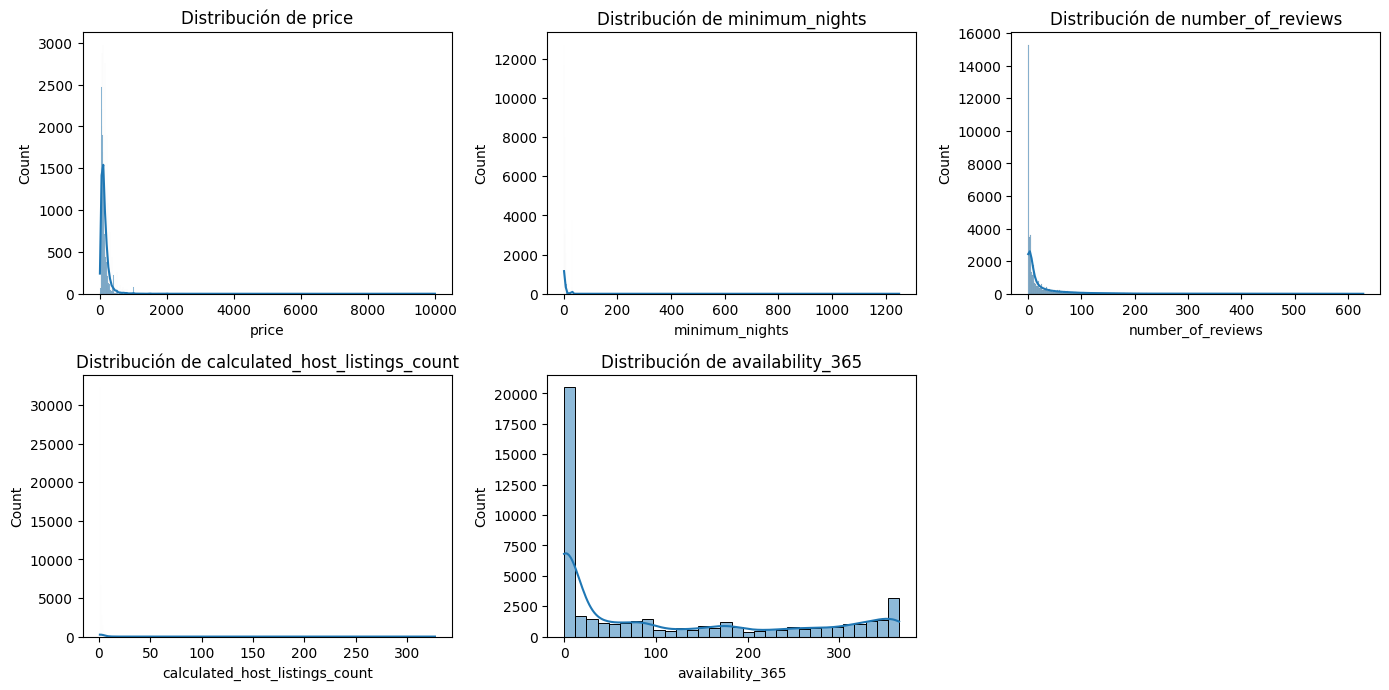

In [69]:
# Histogramas para las variables numéricas
plt.figure(figsize=(14, 10))
for i, var in enumerate(num_vars, 1):
    plt.subplot(3, 3, i)
    sns.histplot(clean_df[var], kde=True)
    plt.title(f'Distribución de {var}')
plt.tight_layout()
plt.show()

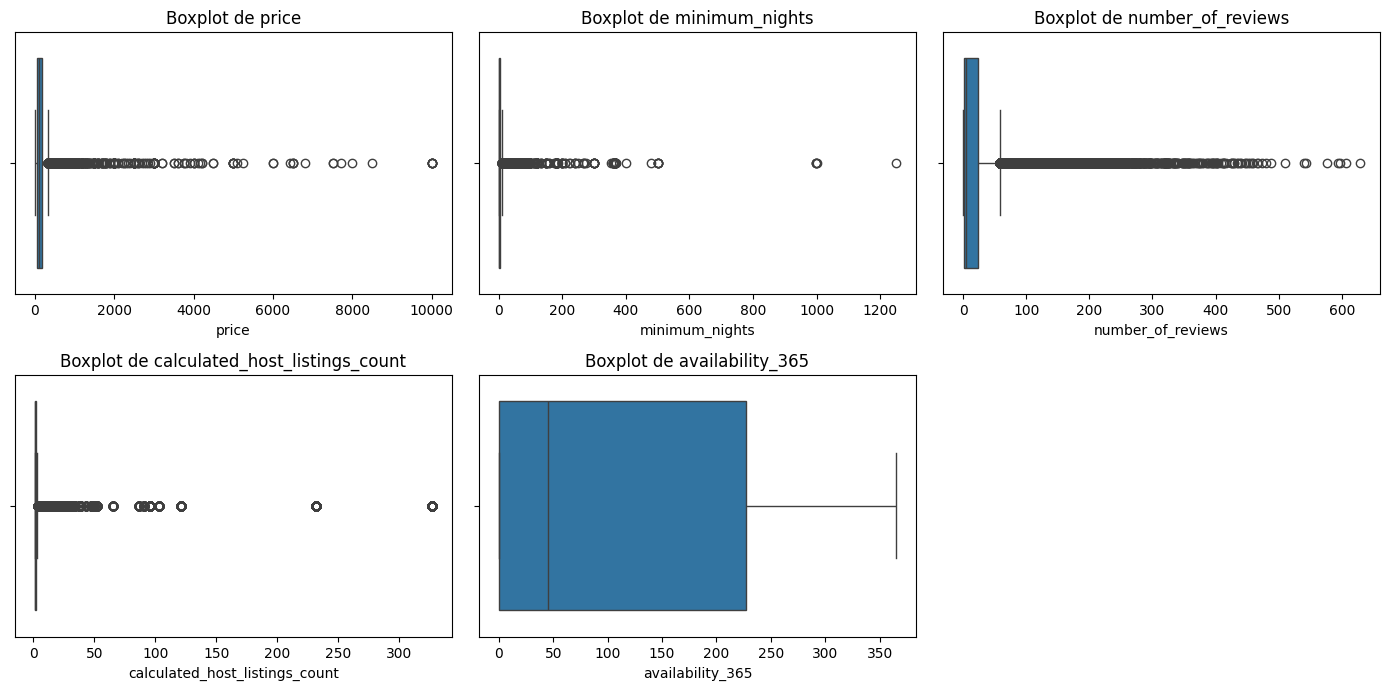

In [70]:
# Boxplots para detectar valores atípicos
plt.figure(figsize=(14, 10))
for i, var in enumerate(num_vars, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=clean_df[var])
    plt.title(f'Boxplot de {var}')
plt.tight_layout()
plt.show()

#### Precio (price):


    Rango: Los precios en el dataset varían ampliamente, con un valor mínimo de 0 y un máximo de 10,000 USD. Este rango sugiere la presencia de valores atípicos.

    Distribución: El histograma y el boxplot indican que hay algunos valores extremadamente altos en el precio (fuera del rango de los cuartiles), lo que podría estar influenciado por errores en la entrada de datos o propiedades de lujo muy raras.

**Decisión:**

    Aunque el máximo es 10,000 USD, la mayoría de los alojamientos están por debajo de 500.
    Eliminar registros con price > 500 USD.

    Esto eliminaría menos del 2% de los datos y evitaría que esos precios extremos distorsionen el modelo.

    También eliminamos price > 10, que probablemente son un error.

In [71]:
# Eliminar outliers en 'price' (por ejemplo, precios menores a 10 o mayores a 1,000)
clean_df = clean_df[(clean_df['price'] > 10) & (clean_df['price'] < 500)]

#### Noches mínimas (minimum_nights):


    Rango: La variable tiene un valor mínimo de 1 y un valor máximo de 1,250 noches. Esto es claramente un valor atípico, ya que las noches mínimas de estancia en un alquiler de Airbnb no deberían ser tan altas.

    Distribución: El boxplot muestra que hay valores muy altos (por encima del percentil 75), lo que indica la presencia de valores atípicos.

**Decisión:**

    Podemos eliminar los valores de noches mínimas superiores a 30 (ya que es poco probable que un alojamiento en Airbnb tenga una restricción de estancia de más de 30 noches).

In [72]:
# Eliminar outliers en 'minimum_nights' (valores mayores a 30 noches)
clean_df = clean_df[clean_df['minimum_nights'] <= 30]

### Variables Categóricas:

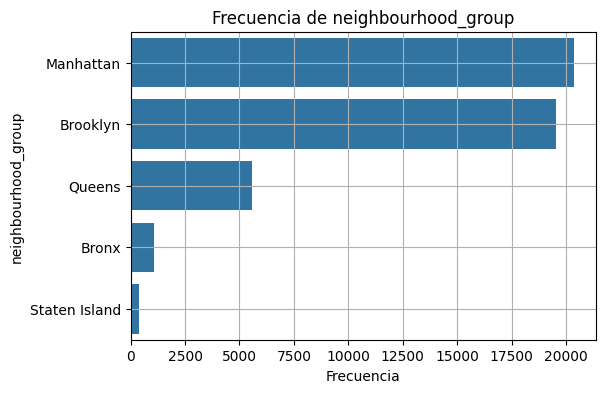

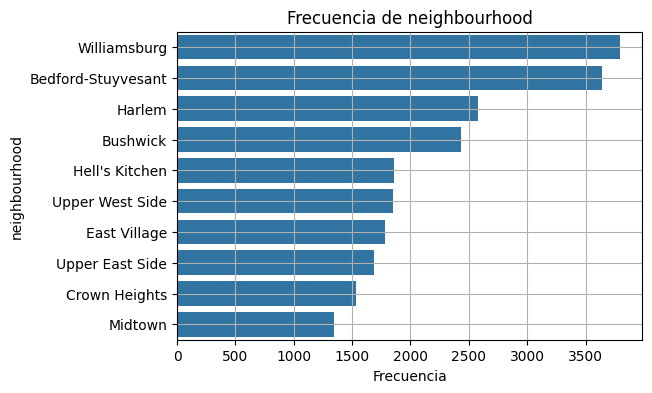

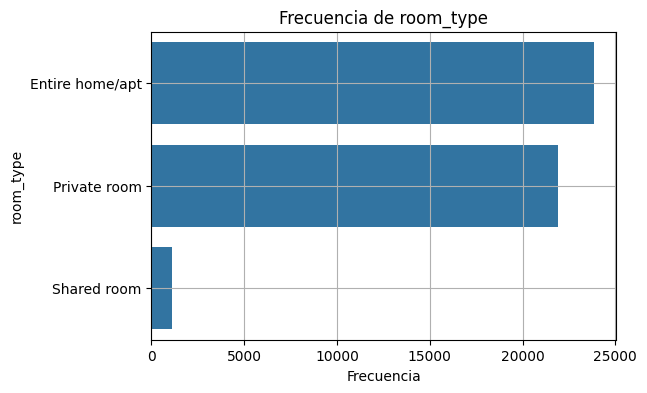

In [73]:
#####  Variables Categóricas
for col in cat_vars:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=clean_df, y=col, order=clean_df[col].value_counts().iloc[:10].index)
    plt.title(f"Frecuencia de {col}")
    plt.xlabel("Frecuencia")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

**Variables Categóricas**

Las variables categóricas nos muestran las frecuencias de las diferentes categorías presentes en el dataset.

**Gráfico de Frecuencia:**

**neighbourhood_group:** Los valores más comunes corresponden a Manhattan, Brooklyn, y Queens, que son las áreas más populares para el alquiler de apartamentos. Otras áreas, como Staten Island o Bronx, tienen una frecuencia mucho menor.

**room_type:** Las opciones más comunes son Entire home/apt (apartamentos completos) y Private room (habitaciones privadas). Las categorías Shared room (habitaciones compartidas) y Hotel room tienen una frecuencia mucho menor.

**Conclusión:**

La mayoría de los alojamientos están ubicados en zonas populares de Manhattan, Brooklyn y Queens.
El tipo de alojamiento más frecuente es el alquiler de apartamentos completos, seguido por habitaciones privadas.
Las categorías con menor frecuencia (habitaciones compartidas y habitaciones de hotel) sugieren que los precios y la demanda pueden estar mucho más concentrados en los otros tipos.

In [74]:
# Codificación de variables categóricas
# Esto es necesario porque los modelos de ML no aceptan texto; get_dummies convierte texto en columnas numéricas binarias
encoded_df = pd.get_dummies(clean_df, columns=['neighbourhood_group', 'neighbourhood', 'room_type'], drop_first=True)

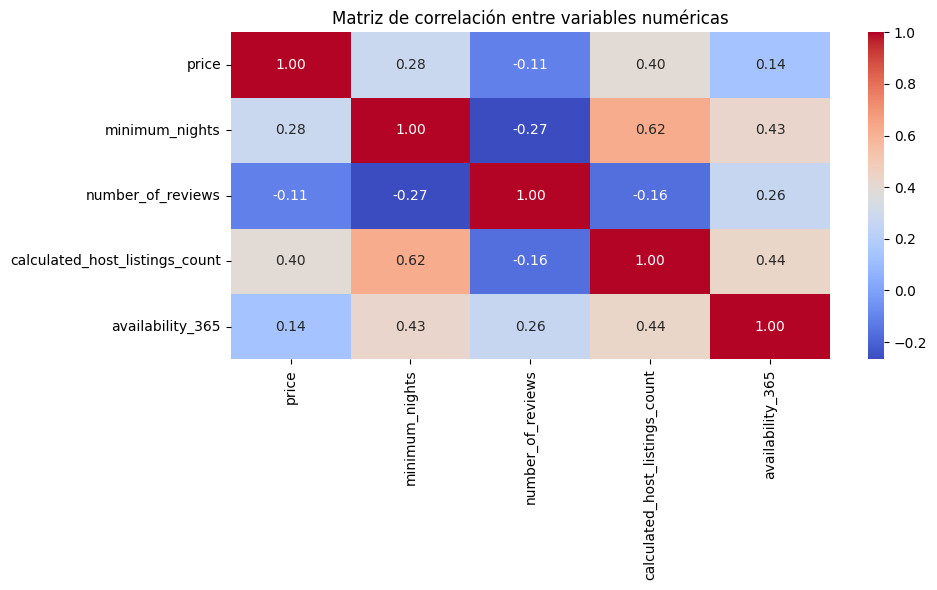

In [75]:
#  Análisis de correlación
plt.figure(figsize=(10, 6))
corr_matrix = encoded_df.corr()
sns.heatmap(corr_matrix[num_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()

**Interpretación general:**


No hay correlaciones extremadamente altas.

Se observa que price tiene correlación positiva con calculated_host_listings_count (0.40) y minimum_nights (0.28).
Tiene ligera correlación negativa con number_of_reviews, lo cual puede reflejar que alojamientos más baratos tienen más reservas.



  


## Análisis multivariado:

#### Análisis numérico-numérico:

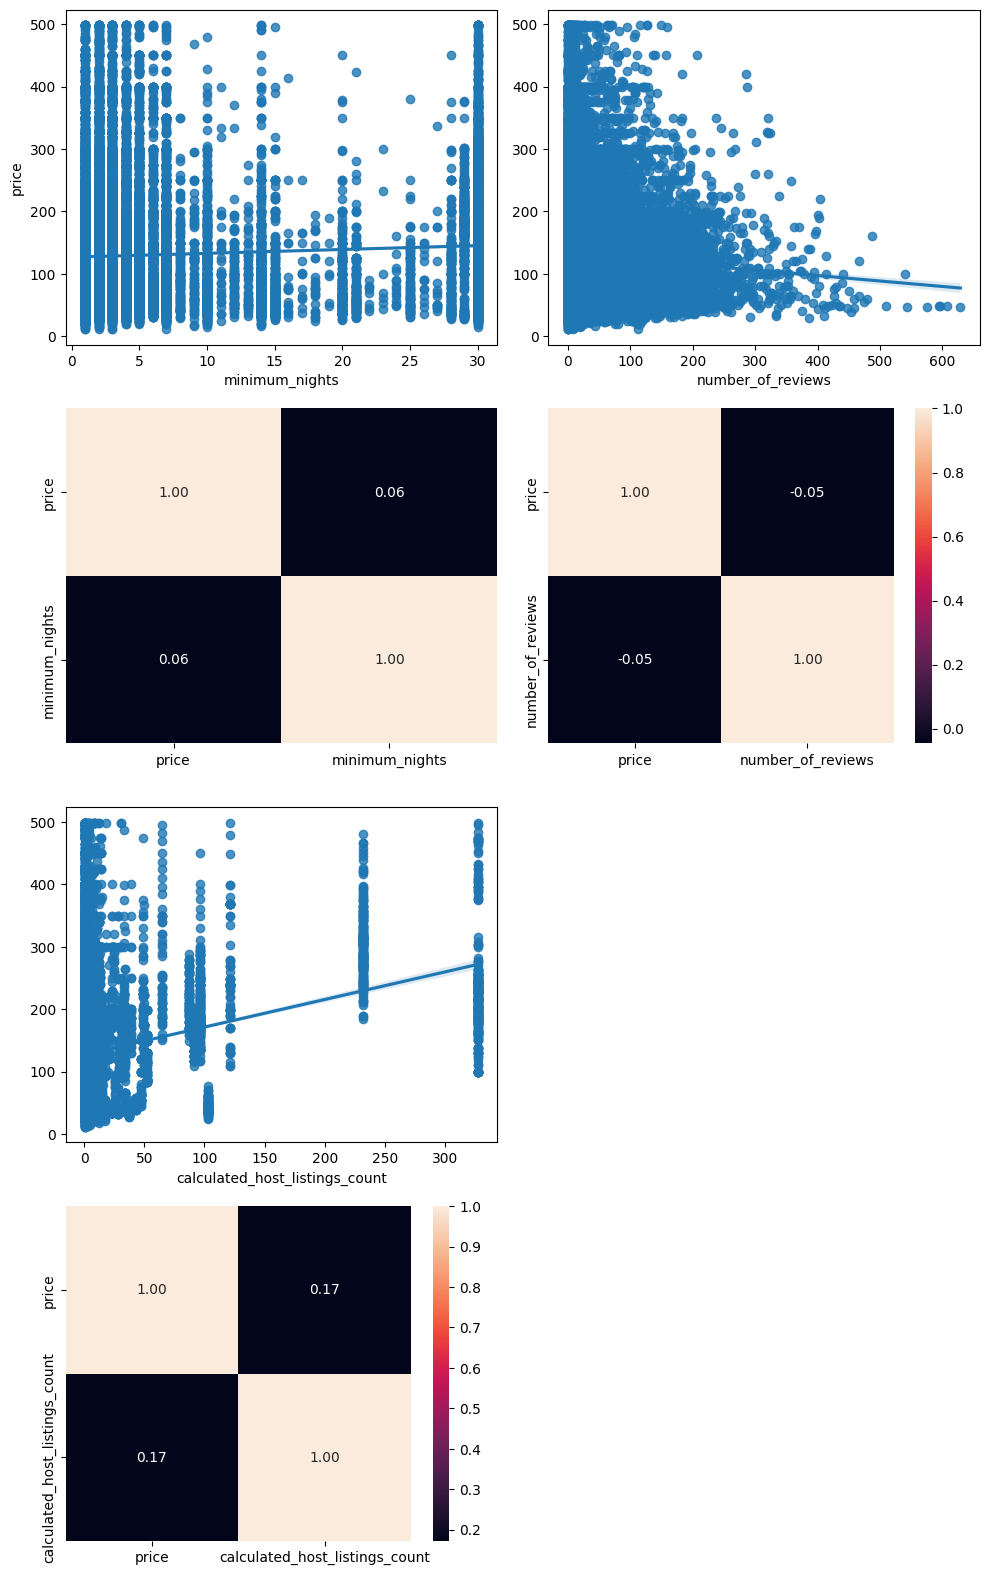

In [77]:

fig, axis = plt.subplots(4, 2, figsize = (10, 16))

sns.regplot(ax = axis[0, 0], data = clean_df, x = "minimum_nights", y = "price")
sns.heatmap(clean_df[["price", "minimum_nights"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = clean_df, x = "number_of_reviews", y = "price").set(ylabel = None)
sns.heatmap(clean_df[["price", "number_of_reviews"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2, 0], data = clean_df, x = "calculated_host_listings_count", y = "price").set(ylabel = None)
sns.heatmap(clean_df[["price", "calculated_host_listings_count"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0]).set(ylabel = None)
fig.delaxes(axis[2, 1])
fig.delaxes(axis[3, 1])

plt.tight_layout()

# Show the plot
plt.show()

Ninguna variable numérica individual tiene una relación fuerte con el precio.

La relación más destacada es con calculated_host_listings_count.

Estas variables pueden aportar algo de información al modelo, pero serán más útiles combinadas con variables categóricas 

#### Análisis categórico-categórico:

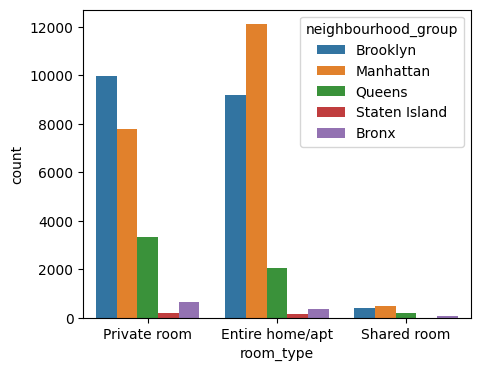

In [78]:
#Relación entre tipo de habitación y vecindario:
fig, axis = plt.subplots(figsize = (5, 4))

sns.countplot(data = clean_df, x = "room_type", hue = "neighbourhood_group")

# Show the plot
plt.show()

Parece que no existe una gran relación entre el tipo de habitación y el vecindario.

#### Análisis numérico-categórico:

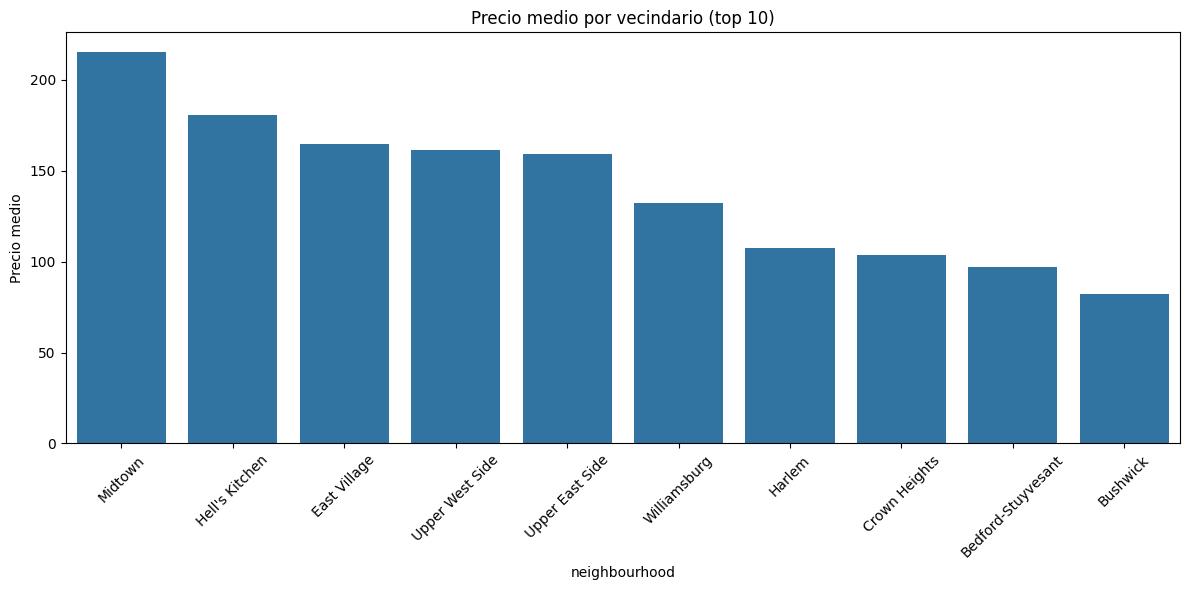

In [79]:
#Precio medio por barrio (Top 10)
price_by_neighbourhood = clean_df.groupby('neighbourhood')['price'].mean()
top_avg_neigh = price_by_neighbourhood[top_neighbourhoods].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_avg_neigh.index, y=top_avg_neigh.values)
plt.xticks(rotation=45)
plt.ylabel("Precio medio")
plt.title("Precio medio por vecindario (top 10)")
plt.tight_layout()
plt.show()

**Conclusión general:**

    El precio promedio varía notablemente entre barrios, incluso dentro de un mismo distrito.

    Esta variable (neighbourhood) es muy útil para predecir precios, y debería mantenerse en el modelo.


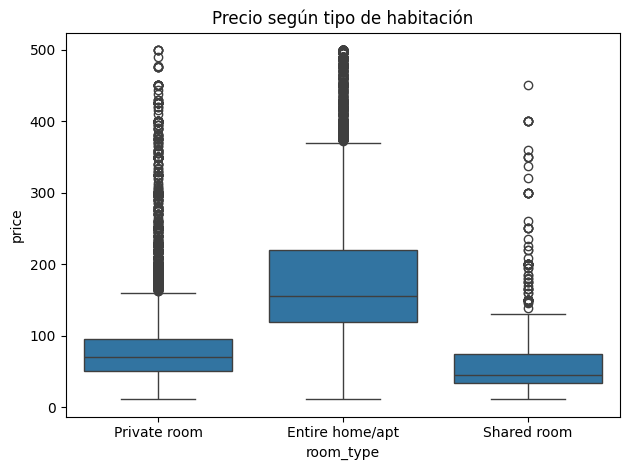

In [80]:
# Relación precio y tipo de habitación
sns.boxplot(data=clean_df, x='room_type', y='price')
plt.title("Precio según tipo de habitación")
plt.tight_layout()
plt.show()

El tipo de habitación influye claramente en el precio.
Los apartamentos completos tienen precios más altos y mayor dispersión.
Las habitaciones privadas y compartidas tienen precios más bajos y menos variabilidad.

## Escalado de variables numéricas

In [81]:
#Los modelos de machine learning (especialmente los que usan distancias o gradientes) suelen beneficiarse del escalado de características.
# Aquí usamos StandardScaler para que cada variable tenga media 0 y desviación estándar 1.
features = encoded_df.drop(columns=['price'])
target = encoded_df['price']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### Selección de variables 

In [82]:
#Con SelectKBest (f_regression):
from sklearn.feature_selection import SelectKBest, f_regression, chi2
k = min(20, features.shape[1])
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(features_scaled, target)
selected_features = features.columns[selector.get_support()]

print("\n--- Mejores variables seleccionadas (f_regression) ---")
print(selected_features)


--- Mejores variables seleccionadas (f_regression) ---
Index(['calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_Bedford-Stuyvesant',
       'neighbourhood_Bushwick', 'neighbourhood_Chelsea',
       'neighbourhood_East Village', 'neighbourhood_Financial District',
       'neighbourhood_Greenwich Village', 'neighbourhood_Hell's Kitchen',
       'neighbourhood_Midtown', 'neighbourhood_Murray Hill',
       'neighbourhood_Tribeca', 'neighbourhood_Upper West Side',
       'neighbourhood_Washington Heights', 'neighbourhood_West Village',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')


In [84]:
# Con chi2:
# La prueba chi2 requiere datos no negativos, por lo que usamos encoded_df directamente (sin escalar)
X = encoded_df.drop(columns=['price'])
y = encoded_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selection_model = SelectKBest(score_func=chi2, k=4)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns[ix])

print("--- Variables seleccionadas con chi2 ---")
print(X_train_sel.columns)


--- Variables seleccionadas con chi2 ---
Index(['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


### Guardar datasets train y test con las variables seleccionadas:

In [87]:
import os
X_train_sel["price"] = list(y_train)
X_test_sel["price"] = list(y_test)

output_dir = "../data/processed"
os.makedirs(output_dir, exist_ok=True)

X_train_sel.to_csv(f"{output_dir}/clean_train.csv", index=False)
X_test_sel.to_csv(f"{output_dir}/clean_test.csv", index=False)
print("\nConjuntos de entrenamiento y prueba guardados en '../data/processed/'")



Conjuntos de entrenamiento y prueba guardados en '../data/processed/'


### Guardar el dataset procesado completo:

In [88]:
os.makedirs("./data/processed", exist_ok=True)
encoded_df.to_csv("./data/processed/airbnb_nyc_2019_cleaned.csv", index=False)
print("\nDataset procesado guardado en './data/processed/airbnb_nyc_2019_cleaned.csv'")



Dataset procesado guardado en './data/processed/airbnb_nyc_2019_cleaned.csv'
